<a href="https://www.kaggle.com/code/ibrahimnibrahim/2020-2025-google-stock-mae-0-1?scriptVersionId=244214235" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2020-2025-google-stock-dataset/google_5yr_one.csv


In [2]:
df=pd.read_csv('/kaggle/input/2020-2025-google-stock-dataset/google_5yr_one.csv')
df=df[1:]
df.head()

,Date,Close,High,Low,Open,Volume
1,2020-06-04,70.3785171508789,71.72309429138843,69.96599205492319,71.4971694316438,26982000
2,2020-06-05,71.65840148925781,71.9709103787135,70.0461071028752,70.44520002096422,42642000
3,2020-06-08,72.05748748779297,72.10525562528537,70.88509140875318,70.974667107052,33878000
4,2020-06-09,72.25852966308594,73.04079279119881,71.77484210279437,71.91816171630913,33624000
5,2020-06-10,72.88652801513672,73.28810385800969,72.37198974644225,72.72778683921254,31762000


In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(1)
    return dataset

def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(15, 10))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)


    plt.title(title)
    plt.grid(True)
    plt.show()

def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

In [4]:
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import StandardScaler

dataset = df["Close"]
dataset = pd.DataFrame(dataset)


scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

train_set, test_set = train_test_split(scaled_data, test_size=0.2, shuffle=False)

In [5]:
time_step=np.arange(0,len(train_set))
close=train_set[:,0] 
valid_x=np.arange(len(train_set),len(train_set)+len(test_set))
valid_y=test_set[:,0] 


all_close=np.concatenate((close,valid_y))
all_time=np.concatenate((time_step,valid_x))

(test_set.shape,train_set.shape)

((251, 1), (1004, 1))

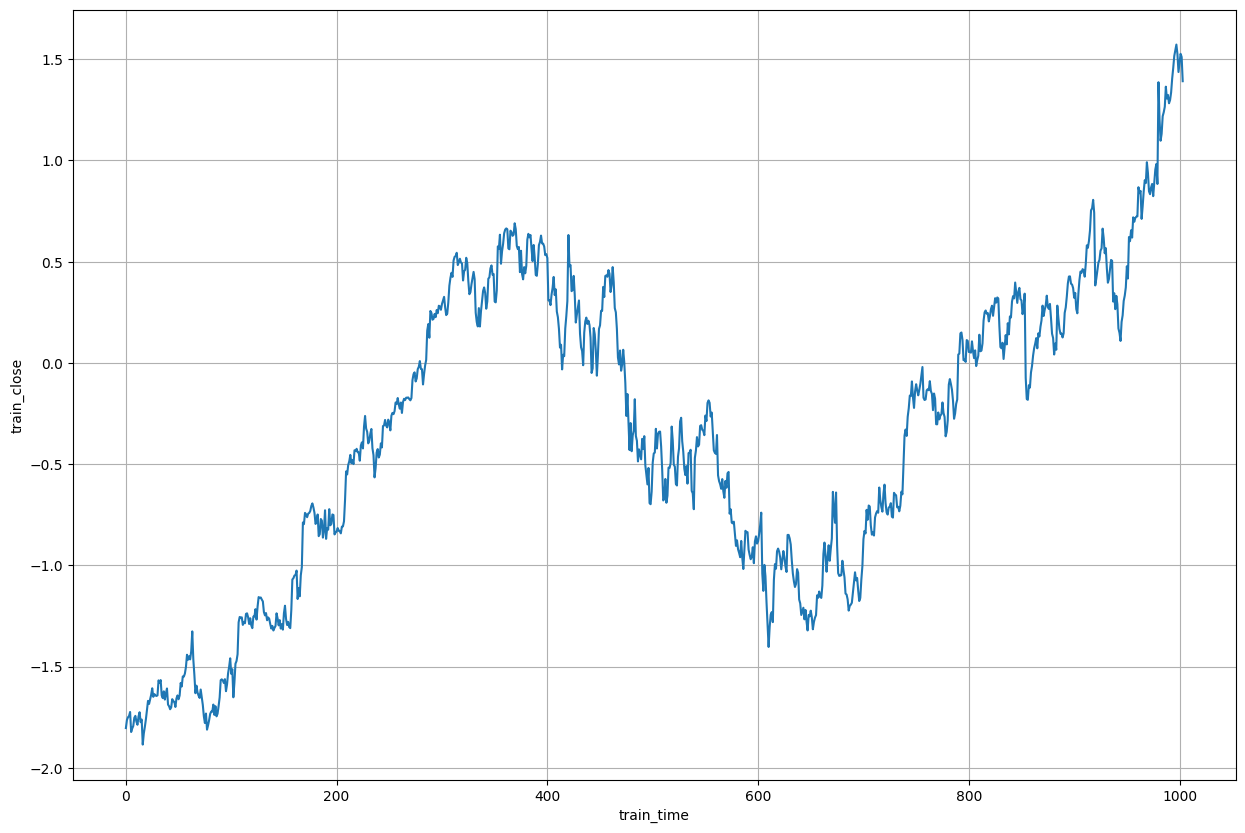

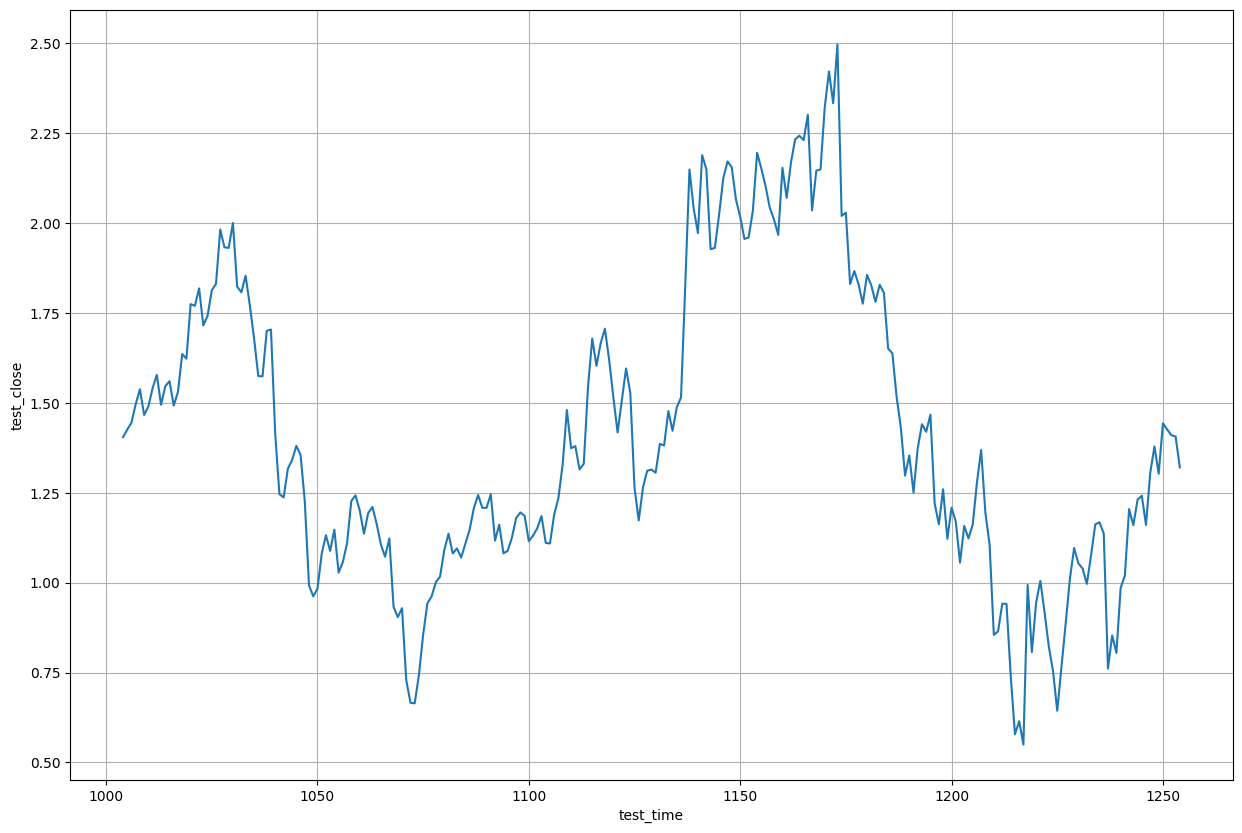

In [6]:
import matplotlib.pyplot as plt

plot_series(time_step,close, xlabel='train_time', ylabel='train_close')
plot_series(valid_x,valid_y, xlabel='test_time', ylabel='test_close')

In [7]:
import tensorflow as tf

# Parameters
window_size = 10
batch_size = 16
shuffle_buffer_size = 5000

train_set = windowed_dataset(close, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(valid_y, window_size, batch_size, shuffle_buffer_size)

2025-06-07 11:29:45.787203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749295785.982501      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749295786.033328      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1749295797.695851      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100)
])

 # Print the model summary 
model.summary()
init_weights = model.get_weights()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 10, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 10, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           6,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,611 (674.26 KB)

 Trainable params: 172,611 (674.26 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))


optimizer = tf.keras.optimizers.SGD(momentum=0.9)
loss=tf.keras.losses.Huber()


model.compile(loss=loss, optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])



Epoch 1/100


I0000 00:00:1749295803.487282      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 3.0180 - learning_rate: 1.0000e-08
Epoch 2/100
25/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8111

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9057 - learning_rate: 1.1220e-08
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7843 - learning_rate: 1.2589e-08
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6601 - learning_rate: 1.4125e-08
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5324 - learning_rate: 1.5849e-08
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4014 - learning_rate: 1.7783e-08
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2666 - learning_rate: 1.9953e-08
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1288 - learning_rate: 2.2387e-08
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9955 - learning_rate: 2.5119e-08
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8657 - learning_rate: 2.8184e-08
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7373 - learning_rate: 3.1623e-08
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6070 - l

(1e-08, 0.001, 0.0, 0.1)

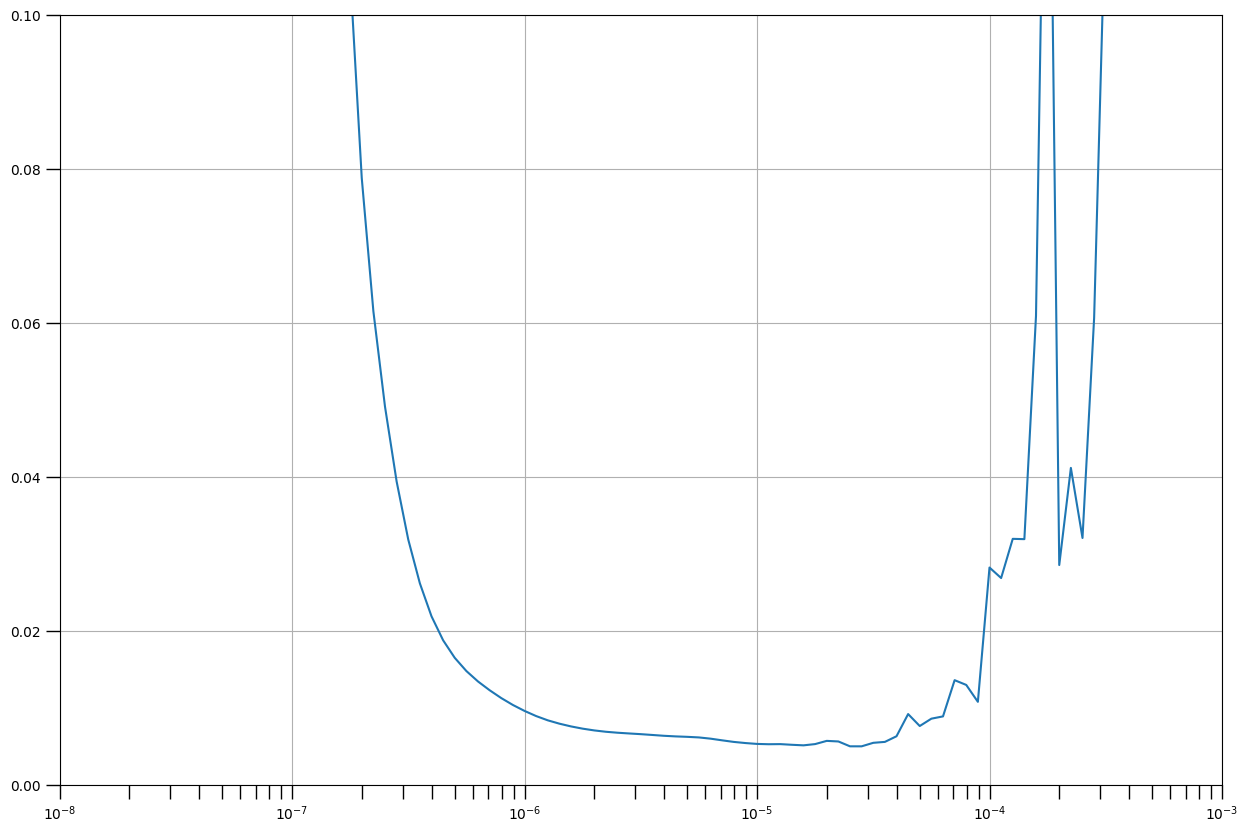

In [10]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(15, 10))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 0.1])

In [11]:
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

# Set the learning rate
learning_rate = 1e-5

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["mae"])

model.fit(train_set,epochs=100)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.7751 - mae: 2.1581
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0247 - mae: 0.1793
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0105 - mae: 0.1115
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0083 - mae: 0.0991
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - mae: 0.0911
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0063 - mae: 0.0857
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0058 - mae: 0.0817
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - mae: 0.0785
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - mae: 0.0759
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0048 - mae: 0.0738
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0047 - mae: 0.0726
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - mae: 0.0715
Epoch 13/100
63/63 ━━━━━━━━━━━━━

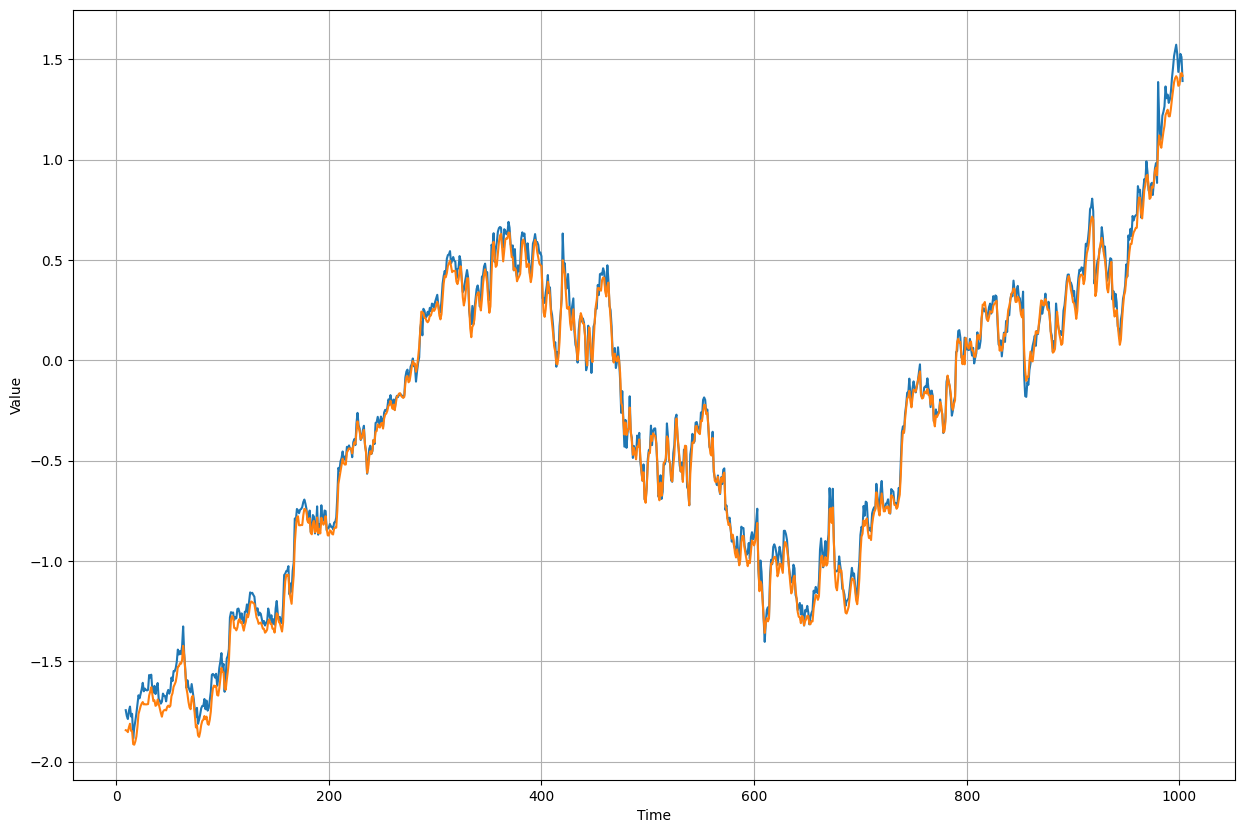

In [12]:
forecast_series = close
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(time_step[window_size-1:],(close[window_size-1:],results), xlabel='Time', ylabel='Value')

mae_all=tf.keras.metrics.mae(close[window_size-1:], results).numpy()

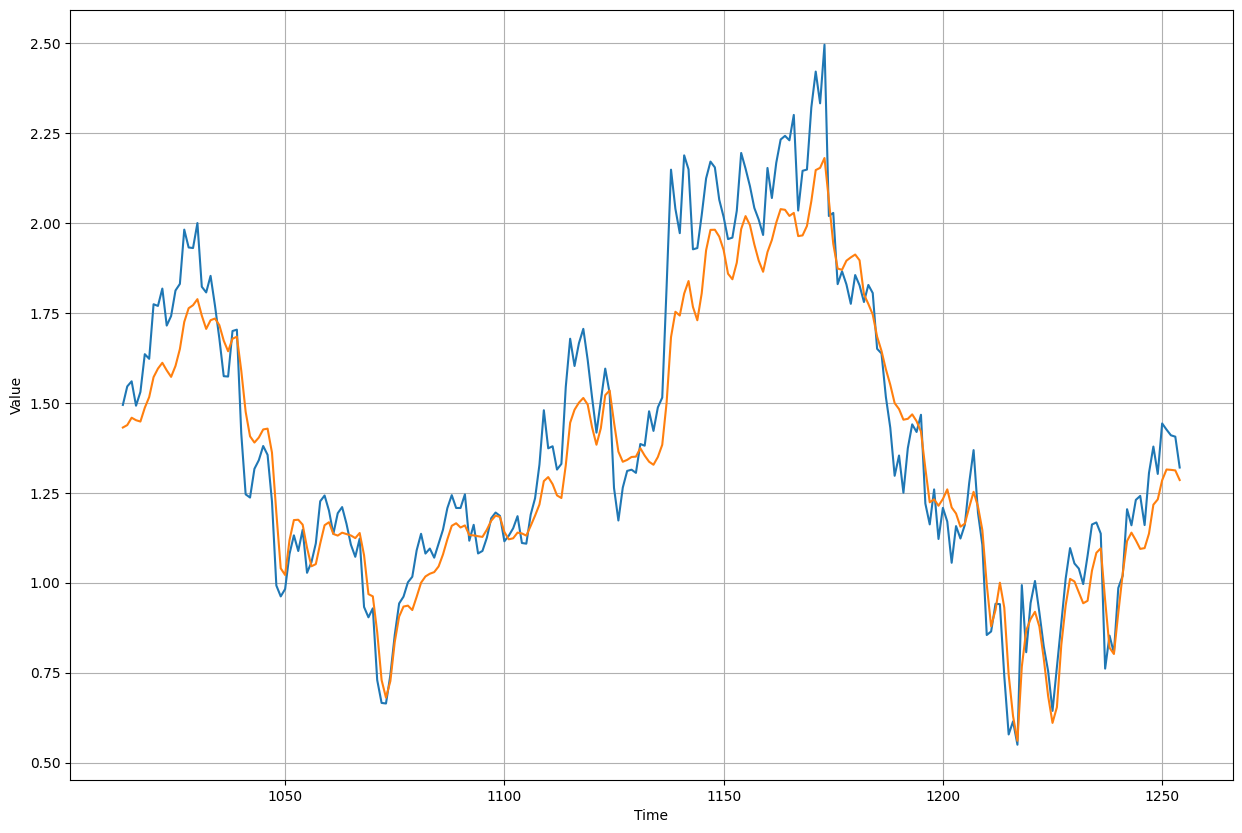

In [13]:
forecast_series = valid_y
forecast = model_forecast(model, forecast_series, window_size, batch_size)
results = forecast.squeeze()
plot_series(valid_x[window_size-1:],(valid_y[window_size-1:],results), xlabel='Time', ylabel='Value')

mae_test=tf.keras.metrics.mae(valid_y[window_size-1:], results).numpy()

In [14]:
print(f'MAE for all the DATASET: {mae_all}')
print(f'MAE for the Test DATASET: {mae_test}')

MAE for all the DATASET: 0.041111961007118225
MAE for the Test DATASET: 0.09911668300628662
